### BLIP image captioning

In [ ]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
import pandas as pd

In [2]:
# load reddit metadata
meme_df = pd.read_json('../data/memesfinal.json')
#meme_df['filetype'] = meme_df.url.apply(lambda x: x.split('.')[-1]); meme_df['filetype'] = meme_df['filetype'].apply(lambda x: x if len(x) <= 4 else 'jpg'); meme_df['filename'] = meme_df['id'] + '.' + meme_df['filetype']
meme_df.head()

,Unnamed: 0.1,Unnamed: 0,id,title,text,score,num_comments,over18,url,date,IDURL,filetype,filename_x,filename_y,vgg_objs,vgg_probs
0,0,612615,2021.02.15_288,Wait I didn't mean it like that,None,211152,1642,False,https://i.redd.it/n4ildkpurph61.png,2021-02-15,Wait I didn't mean it like thathttps://i.redd....,png,2021.02.15_288.png,"[[[n06359193, web_site, 0.6105720997], [n02841...","[web_site, binoculars, comic_book, book_jacket...","[0.6105720997, 0.0365490019, 0.025503724800000..."
1,1,545780,2020.10.20_959,Don't be mad,None,207206,811,False,https://i.redd.it/gsqgq6uwuau51.jpg,2020-10-20,Don't be madhttps://i.redd.it/gsqgq6uwuau51.jpg,jpg,2020.10.20_959.jpg,"[[[n06359193, web_site, 0.5064607263], [n03782...","[web_site, monitor, white_wolf, screen, televi...","[0.5064607263, 0.1039560139, 0.1010734811, 0.0..."
2,2,385925,2020.01.18_675,For real tho,None,207066,1734,False,https://i.redd.it/eg4t9kvlplb41.jpg,2020-01-18,For real thohttps://i.redd.it/eg4t9kvlplb41.jpg,jpg,2020.01.18_675.jpg,"[[[n02730930, apron, 0.23828053470000002], [n0...","[apron, backpack, envelope, pillow, comic_book]","[0.23828053470000002, 0.1158946604, 0.06027054..."
3,3,468558,2020.06.09_755,Right as rain after that,None,187936,743,False,https://i.redd.it/1wniz8ionv351.jpg,2020-06-09,Right as rain after thathttps://i.redd.it/1wni...,jpg,2020.06.09_755.jpg,"[[[n06359193, web_site, 0.26609888670000004], ...","[web_site, envelope, rule, sewing_machine, desk]","[0.26609888670000004, 0.12914824490000001, 0.1..."
4,4,485415,2020.07.08_336,Licensed Dad Joke,None,182056,616,False,https://i.redd.it/nrj9smsfek951.jpg,2020-07-08,Licensed Dad Jokehttps://i.redd.it/nrj9smsfek9...,jpg,2020.07.08_336.jpg,"[[[n02114548, white_wolf, 0.6159376502], [n021...","[white_wolf, Samoyed, chow, ice_bear, Arctic_fox]","[0.6159376502, 0.2730476558, 0.0343475901, 0.0..."


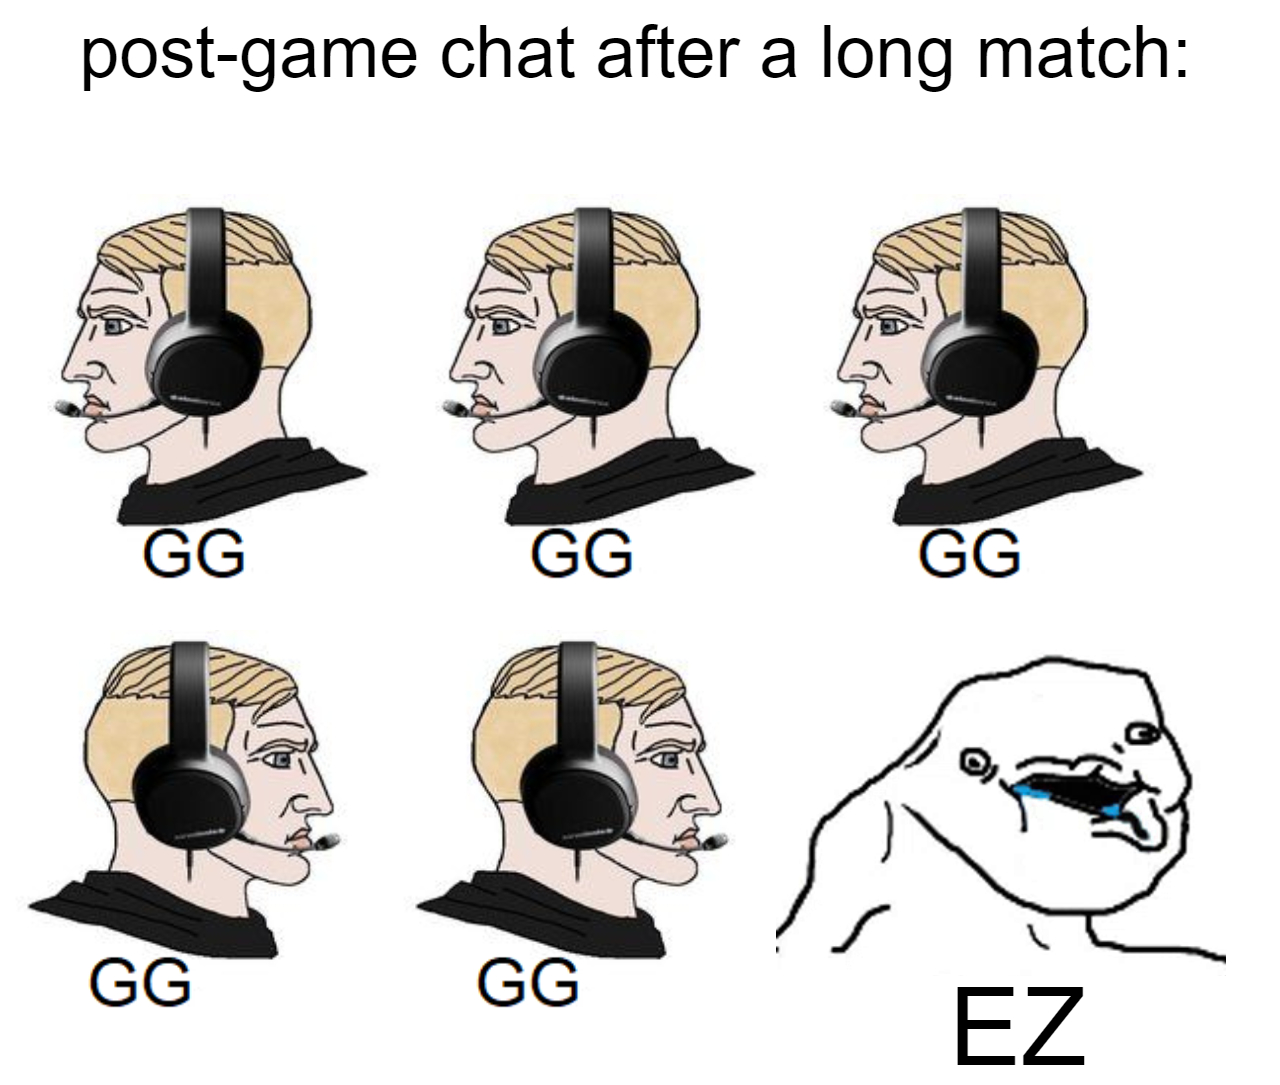

In [3]:
# load meme images from local filepath
filename = meme_df.at[80, 'filename_x'] \
path_to_file = '../data/Memes2022Final2/' + filename
img =Image.open(path_to_file).convert("RGB")
display(img)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption",model_type="large_coco",is_eval=True,device=device)
vis_processors.keys()

dict_keys(['train', 'eval'])

In [6]:
%%time
image = vis_processors["eval"](img).unsqueeze(0).to(device)

CPU times: total: 46.9 ms
Wall time: 43 ms


In [7]:
%%time
model.generate({"image":image})

CPU times: total: 1min 34s
Wall time: 25.8 s


['a drawing of a man with headphones on and the words postgame chat after a long match']

In [8]:
# load data that was already captioned
df = pd.read_parquet('../data/reddit_captions.parquet')
df.head()

,image_path,caption
0,D:/Memes2022Final2_resized\2014.01.01_14.jpg,a man wearing a hat and a white shirt
1,D:/Memes2022Final2_resized\2014.01.01_15.jpg,a black and white image of a face with a capti...
2,D:/Memes2022Final2_resized\2014.01.01_17.gif,a person holding a cell phone up to a qr code
3,D:/Memes2022Final2_resized\2014.01.01_2.jpg,a woman holding a black cat in her arms
4,D:/Memes2022Final2_resized\2014.01.01_3.jpg,a man with a beard and a white shirt


In [ ]:
# put captioning in loop and save files
from tqdm import tqdm

counter = 1

for i in tqdm(to_process.index):

    filename = to_process.at[i, 'filename_x'] 
    path_to_file = '../data/Memes2022Final2/' + filename
    img =Image.open(path_to_file).convert("RGB")

    image = vis_processors["eval"](img).unsqueeze(0).to(device)

    to_process.at[i,'caption'] = model.generate({"image":image})
    counter +=1

    # after every 10000 rows save progress
    if counter%10000==0:
        save = pd.DataFrame({'id':to_process['id_y'],'caption':to_process['caption']})
        save.to_json('meme_captions_reversed_'+str(counter)+'.json')

  0%|                                                                          | 3/312469 [00:59<1645:00:33, 18.95s/it]